#  Example 4: Cation exchange- flushing of a sodium-potassium nitrate solution with calcium chloride
This modelling example is the first among several examples that include and demonstrate ion-exchanging reactions in flow-through systems. The example was originally used as PHREEQM (Nienhuis et al., 1994) test case, and is also included in the PHREEQC-3 documentation (Parkhurst and Appelo, 2013) as Example 11. Further discussion can be found in (Appelo and Postma, 1993), where it forms Example 10.13, and in (Appelo, 1994). The one-dimensional simulation problem describes a hypothetical column experiment where porewater containing sodium (Na<sup>+</sup>), potassium (K<sup>+</sup>) and nitrate (NO<sup>-</sup><sub>3</sub>) in equilibrium with exchangeable cations is flushed by a calcium chloride (CaCl<sub>2</sub>) solution

In [1]:
from pathlib import Path
import os
from modflowapi.extensions import ApiSimulation
from modflowapi import Callbacks
# from workflow import *
from datetime import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#add mf6rtm path to the system
import flopy
from mf6rtm import utils
from mf6rtm import mf6rtm
import re
import difflib

prefix = 'ex4'
DT_FMT = "%Y-%m-%d %H:%M:%S"
dataws = os.path.join("data")
databasews = os.path.join("database")


#stuff to compare outputs from pht3d and mf6rtm

def find_closest_match(query, dictionary):
    closest_match = difflib.get_close_matches(query, dictionary.keys(), n=1)
    if closest_match:
        return closest_match[0]
    else:
        return None
    
def calc_rows_from_ncol(variables, ncols=4):
    '''
    Calculates number of rows for subplots
    from ncols and len of variables to plot.

    Parameters:
        variables (list or sequence): list of variables to plot
        ncols (int): number of columns to plot
    '''
    n_subplots = len(variables)
    # calculate number of rows
    nrows = n_subplots // ncols + (n_subplots % ncols > 0)
    return nrows

## Flow and Transport Setup

In [2]:
### Model params and setup

# General
length_units = "meters"
time_units = "days"

# Model discretization
nlay = 1  # Number of layers
Lx = 0.08 #m
ncol = 40 # Number of columns
nrow = 1  # Number of rows
delr = Lx/ncol #10.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 1.  # Top of the model ($m$)
# botm = 0.0  # Layer bottom elevations ($m$)
zbotm = 0.
botm = np.linspace(top, zbotm, nlay + 1)[1:]

#tdis
nper = 1  # Number of periods
tstep = 0.002 *0.5 # Time step ($days$)
perlen = 0.24  # Simulation time ($days$)
nstp = perlen/tstep #100.0
dt0 = perlen / nstp
tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

#injection
q = 1 #injection rate m3/d
wel_spd = [[(0,0,0), q]]


#hydraulic properties
prsity = 1 # Porosity
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
strt = np.ones((nlay, nrow, ncol), dtype=float)*1
# two chd one for tailings and conc and other one for hds 

# two chd one for tailings and conc and other one for hds 
r_hd = 1
strt = np.ones((nlay, nrow, ncol), dtype=float)

chdspd = [[(i, 0, ncol-1), r_hd] for i in range(nlay)] # Constant head boundary $m$
# chdspd.extend([(i, 0, ncol - 1), r_hd] for i in range(nlay))

# chdspd_tail = [[(i, 0, 0), l_hd] for i in range(0,3)]

#transport
dispersivity = 0.002 # Longitudinal dispersivity ($m$)
disp_tr_vert = dispersivity*0.1 # Transverse vertical dispersivity ($m$)


icelltype = 1  # Cell conversion type
# ibound = np.ones((nlay, nrow, ncol), dtype=int)
# ibound[:, 0, -1] = -1
# ibound[:, 0, 0] = -1

# Set solver parameter values (and related)
nouter, ninner = 300, 600
hclose, rclose, relax = 1e-6, 1e-6, 1.0

## Initialize Chemistry in Domain

In [3]:
files = [f for f in os.listdir(dataws) if f.startswith(prefix)]

solutionsdf = pd.read_csv(os.path.join(dataws,f"{prefix}_solutions.csv"), comment = '#',  index_col = 0)

# solutions = utils.solution_csv_to_dict(os.path.join(dataws,f"{prefix}_solutions.csv"))
solutions = utils.solution_df_to_dict(solutionsdf)



In [4]:
#assign solutions to grid
sol_ic = np.ones((nlay, nrow, ncol), dtype=float)
# sol_ic = 1
#add solutions to clss
solution = mf6rtm.Solutions(solutions)
solution.set_ic(sol_ic)

excdf = pd.read_csv(os.path.join(dataws,f"{prefix}_exchange.csv"), comment = '#',  index_col = 0)
exchangerdic = utils.solution_df_to_dict(excdf)

exchanger = mf6rtm.ExchangePhases(exchangerdic)
exchanger.set_ic(np.ones((nlay, nrow, ncol), dtype=float))

#create model class
model = mf6rtm.Mup3d(prefix,solution, nlay, nrow, ncol)

#set model workspace
model.set_wd(os.path.join(f'{prefix}',f'mf6rtm'))

#set database
database = os.path.join(databasews, f'pht3d_datab.dat')
model.set_database(database)

model.set_exchange_phases(exchanger)

#get postfix file
postfix = os.path.join(dataws, f'{prefix}_postfix.phqr')
model.set_postfix(postfix)


In [5]:
model.initialize()

Using temperatue of 25.0 for all cells
Phreeqc initialized


## Initialize Inflow Chemistry

In [6]:
wellchem = mf6rtm.ChemStress('wel')
sol_spd = [2]
sol_spd
wellchem.set_spd(sol_spd)
model.set_chem_stress(wellchem)
model.wel.data

Initializing ChemStress
ChemStress wel initialized


{0: [110684.17114503865,
  55342.08558975302,
  -1.3109877640770234e-06,
  0.5982258070710699,
  1.1964516141421357,
  0.0,
  0.0,
  0.0]}

In [7]:
for i in range(len(wel_spd)):
    wel_spd[i].extend(model.wel.data[i])
print(wel_spd)

[[(0, 0, 0), 1, 110684.17114503865, 55342.08558975302, -1.3109877640770234e-06, 0.5982258070710699, 1.1964516141421357, 0.0, 0.0, 0.0]]


In [8]:
wel_spd

[[(0, 0, 0),
  1,
  110684.17114503865,
  55342.08558975302,
  -1.3109877640770234e-06,
  0.5982258070710699,
  1.1964516141421357,
  0.0,
  0.0,
  0.0]]

## Build MF6 Model

In [9]:
def build_model(mup3d):

    #####################        GWF model           #####################
    gwfname = 'gwf'
    sim_ws = mup3d.wd
    sim = flopy.mf6.MFSimulation(sim_name=mup3d.name, sim_ws=sim_ws, exe_name='mf6')

    # Instantiating MODFLOW 6 time discretization
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        complexity="complex",
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=np.ones((nlay, nrow, ncol), dtype=int),
        filename=f"{gwfname}.dis",
    )
    dis.set_all_data_external()

    # Instantiating MODFLOW 6 node-property flow package
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        save_saturation = True,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )
    npf.set_all_data_external()
    # sto = flopy.mf6.ModflowGwfsto(gwf, ss=1e-6, sy=0.25)

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")
    
    wel = flopy.mf6.ModflowGwfwel(
            gwf,
            stress_period_data=wel_spd,
            save_flows = True,
            auxiliary = model.components,
            pname = 'wel',
            filename=f"{gwfname}.wel"
        )
    wel.set_all_data_external()

    # Instantiating MODFLOW 6 constant head package
    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        # auxiliary=mup3d.components,
        save_flows=False,
        pname="CHD",
        filename=f"{gwfname}.chd",
    )
    chd.set_all_data_external()

    # Instantiating MODFLOW 6 output control package for flow model
    oc_gwf = flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.cbb",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    
    #####################           GWT model          #####################
    for c in mup3d.components:
        print(f'Setting model for component: {c}')
        gwtname = c
        
        # Instantiating MODFLOW 6 groundwater transport package
        gwt = flopy.mf6.MFModel(
            sim,
            model_type="gwt6",
            modelname=gwtname,
            model_nam_file=f"{gwtname}.nam"
        )

        # create iterative model solution and register the gwt model with it
        print('--- Building IMS package ---')
        imsgwt = flopy.mf6.ModflowIms(
            sim,
            print_option="SUMMARY",
            outer_dvclose=hclose,
            outer_maximum=nouter,
            under_relaxation="NONE",
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord=rclose,
            linear_acceleration="BICGSTAB",
            scaling_method="NONE",
            reordering_method="NONE",
            relaxation_factor=relax,
            filename=f"{gwtname}.ims",
        )
        sim.register_ims_package(imsgwt, [gwt.name])

        print('--- Building DIS package ---')
        dis = gwf.dis

        # create grid object
        dis = flopy.mf6.ModflowGwtdis(
            gwt,
            length_units=length_units,
            nlay=nlay,
            nrow=nrow,
            ncol=ncol,
            delr=delr,
            delc=delc,
            top=top,
            botm=botm,
            idomain=np.ones((nlay, nrow, ncol), dtype=int),
            filename=f"{gwtname}.dis",
        )
        dis.set_all_data_external()

         
        ic = flopy.mf6.ModflowGwtic(gwt, strt=mup3d.sconc[c], filename=f"{gwtname}.ic")
        ic.set_all_data_external()
        
        # Instantiating MODFLOW 6 transport source-sink mixing package
        sourcerecarray = ['wel', 'aux', f'{c}']
        # sourcerecarray = [()]
        ssm = flopy.mf6.ModflowGwtssm(
            gwt, 
            sources=sourcerecarray, 
            save_flows=True,
            print_flows=True,

            filename=f"{gwtname}.ssm"
        )
        ssm.set_all_data_external()
        # Instantiating MODFLOW 6 transport adv package
        print('--- Building ADV package ---')
        adv = flopy.mf6.ModflowGwtadv(
            gwt,
            scheme="tvd",
        )

        # Instantiating MODFLOW 6 transport dispersion package
        alpha_l = np.ones(shape=(nlay, nrow, ncol))*dispersivity  # Longitudinal dispersivity ($m$)
        ath1 = np.ones(shape=(nlay, nrow, ncol))*dispersivity*0.1 # Transverse horizontal dispersivity ($m$)
        atv = np.ones(shape=(nlay, nrow, ncol))*dispersivity*0.1   # Transverse vertical dispersivity ($m$)

        print('--- Building DSP package ---')
        dsp = flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            alh=alpha_l,
            ath1=ath1,
            atv = atv,
            # diffc = diffc,
            filename=f"{gwtname}.dsp",
        )
        dsp.set_all_data_external()

        # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
        print('--- Building MST package ---')

        first_order_decay = None

        mst = flopy.mf6.ModflowGwtmst(
            gwt,
            porosity=prsity,
            first_order_decay=first_order_decay,
            filename=f"{gwtname}.mst",
        )
        mst.set_all_data_external()

        print('--- Building OC package ---')

        # Instantiating MODFLOW 6 transport output control package
        oc_gwt = flopy.mf6.ModflowGwtoc(
            gwt,
            budget_filerecord=f"{gwtname}.cbb",
            concentration_filerecord=f"{gwtname}.ucn",
            concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 10, "GENERAL")
                                        ],
            saverecord=[("CONCENTRATION", "ALL"), 
                        ("BUDGET", "ALL")
                        ],
            printrecord=[("CONCENTRATION", "ALL"), 
                            ("BUDGET", "ALL")
                            ],
        )

        # Instantiating MODFLOW 6 flow-transport exchange mechanism
        flopy.mf6.ModflowGwfgwt(
            sim,
            exgtype="GWF6-GWT6",
            exgmnamea=gwfname,
            exgmnameb=gwtname,
            filename=f"{gwtname}.gwfgwt",
        )

    sim.write_simulation()
    utils.prep_bins(sim_ws, src_path=os.path.join('..','bin'))
    
    return sim

In [10]:
sim = build_model(model)

Setting model for component: H
--- Building IMS package ---
--- Building DIS package ---


--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: O
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Charge
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Ca
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Cl
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: K
--- Building IMS package ---
--

--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: N
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
Setting model for component: Na
--- Building IMS package ---
--- Building DIS package ---
--- Building ADV package ---
--- Building DSP package ---
--- Building MST package ---
--- Building OC package ---
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ims_0...
  writing solution package ims_1...
  writing solution package ims_2...
  writing solution package ims_3...
  writing solution package ims_4...
  writing solution package ims_5...
  writing solution package ims_6...
  writing solution package ims_7...
  writing package H.gwfgwt...
  writing package O.gwfgwt..

    writing package mst...
    writing package oc...
  writing model Charge...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model Ca...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model Cl...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package oc...
  writing model K...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package ssm...
    writing package adv...
    writing package dsp...
    writing package mst...
    writin

In [11]:
model.run_mup3d(sim, reaction=True)



-----------------------------  WELCOME TO  MUP3D -----------------------------

Transporting the following components: Flow, H, O, Charge, Ca, Cl, K, N, Na


Starting transport solution at 2024-08-06 12:54:01

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took 0.00016668 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 1 --- converged with 1 iters --- took 0.00019995 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 1 --- converged with 8 iters --- took  0.0002333 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 1 --- converged with 8 iters --- took 0.00026668 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 1 --- converged with 14 iters --- took 0.00031667 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 1 --- converged with 20 iters --- took 0.00036658 mins

Solution 6 finalized

Solving solution 7 - Solving K
Trans


Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 5 --- converged with 0 iters --- took 0.00010035 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 5 --- converged with 3 iters --- took 0.00013325 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 5 --- converged with 9 iters --- took 0.00018325 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 5 --- converged with 9 iters --- took 0.00021685 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 5 --- converged with 15 iters --- took 0.00025235 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 5 --- converged with 20 iters --- took 0.00028555 mins

So


Getting concentration arrays --- time step: 8 --- elapsed time: 0.007

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 9 --- converged with 0 iters --- took 0.00012975 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 9 --- converged with 3 iters --- took 0.00017912 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 9 --- converged with 8 iters --- took 0.00024603 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transpo


Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 12 --- converged with 0 iters --- took 0.00016067 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 12 --- converged with 3 iters --- took 0.00021307 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 12 --- converged with 8 iters --- took 0.00026313 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 12 --- converged with 8 iters --- took 0.00031303 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 12 --- converged with 14 iters --- took 0.00037982 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 12 --- converged with 19 iters --- took 0.00043025 mins

Solution 6 finalized

Solving solution 7 - Solvin


Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 15 --- converged with 0 iters --- took 0.00012752 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 15 --- converged with 3 iters --- took 0.00016183 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 15 --- converged with 8 iters --- took  0.0002304 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 15 --- converged with 8 iters --- took 0.00026375 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 15 --- converged with 14 iters --- took 0.00031255 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 15 --- converged with 18 iters --- took  0.0003803 mi


Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 18 --- converged with 19 iters --- took 0.00036413 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 18 --- converged with 24 iters --- took 0.00041415 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 18 --- converged with 28 iters --- took 0.00044752 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 18 --- converged with 33 iters --- took 0.00049762 mins

Solution 9 finalized

Getting concentration arrays --- time step: 18 --- elapsed time: 0.017000000000000008

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to

Transport stress period: 1 --- time step: 22 --- converged with 7 iters --- took  0.0002017 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 22 --- converged with 7 iters --- took 0.00023505 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 22 --- converged with 13 iters --- took 0.00030163 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 22 --- converged with 17 iters --- took 0.00033507 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 22 --- converged with 22 iters --- took 0.00038035 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 22 --- converged with 26 iters --- took 0.00043028 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 22 --- converged with 31 iters --- took 


Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 26 --- converged with 0 iters --- took  8.345E-05 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 26 --- converged with 4 iters --- took 0.00013328 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 26 --- converged with 8 iters --- took 0.00016675 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 26 --- converged with 8 iters --- took 0.00020022 mins

Solution 4 finalized

Solving 


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 30 --- converged with 0 iters --- took 0.00011198 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 30 --- converged with 3 iters --- took 0.00016197 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 30 --- converged with 7 iters --- took 0.00019542 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 30 --- converged with 7 iters --- took 0.00022897 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 30 --- converged with 13 iters --- took 0.00029533 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 30 --- converged with 16 iters --- took 0.00032867 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 30 --- c


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 34 --- converged with 0 iters --- took 0.00010008 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 34 --- converged with 4 iters --- took 0.00015033 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 34 --- converged with 8 iters --- took  0.0001835 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 34 --- converged with 8 iters ---


Getting concentration arrays --- time step: 37 --- elapsed time: 0.036000000000000025

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 38 --- converged with 0 iters --- took  8.335E-05 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 38 --- converged with 4 iters --- took 0.00013323 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 38 --- converged with 7 iters --- took  0.0001666 mins

Solution 3 finalized

Solving solution 4 - Sol


Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 42 --- converged with 0 iters --- took 0.00011647 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 42 --- converged with 4 iters --- took 0.00016715 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 42 --- converged with 8 iters --- took 0.00019993 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 42 --- converged with 8 iters --- took 0.00023307 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 42 --- converged with 14 iters --- took 0.00026657 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 46 --- converged with 0 iters --- took 0.00011673 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 46 --- converged with 4 iters --- took  0.0001667 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 46 --- converged with 8 iters --- took 0.00020005 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 46 --- converged with 8 iters ---


Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 49 --- converged with 14 iters --- took 0.00024995 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 49 --- converged with 17 iters --- took  0.0002832 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 49 --- converged with 23 iters --- took  0.0003333 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 49 --- converged with 26 iters --- took 0.00036655 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 49 --- converged with 31 iters --- took  0.0004167 mins

Solution 9 finalized

Getting concentration arrays --- time step: 49 --- elapsed time: 0.048000000000000036

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for comp


Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 53 --- converged with 4 iters --- took 0.00016683 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 53 --- converged with 8 iters --- took     0.0002 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 53 --- converged with 8 iters --- took 0.00023398 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 53 --- converged with 14 iters --- took 0.00028332 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 53 --- converged with 18 iters --- took 0.00033328 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 53 --- converged with 25 iters --- took 0.00040002 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 53 --- con


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 57 --- converged with 0 iters --- took 0.00011673 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 57 --- converged with 5 iters --- took 0.00016908 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 57 --- converged with 9 iters --- took 0.00021895 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 57 --- converged with 9 iters --- took 0.00023563 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 57 --- converged with 15 iters --- took 0.00028548 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 57 --- converged with 19 iters --- took  0.0003191 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 57 --- c


Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 61 --- converged with 0 iters --- took 0.00011653 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 61 --- converged with 5 iters --- took 0.00018318 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 61 --- converged with 9 iters --- took 0.00022837 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 61 --- converged with 9 iters --- took 0.00026198 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 61 --- converged with 15 iters --- took   0.000295 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 61 --- converged with 19 iters --- took 0.00032837 mi


Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 65 --- converged with 0 iters --- took 0.00011245 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 65 --- converged with 5 iters --- took 0.00019565 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 65 --- converged with 9 iters --- took  0.0002293 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 65 --- converged with 9 iters --- took 0.00026245 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 69 --- converged with 0 iters --- took 0.00015028 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 69 --- converged with 5 iters --- took  0.0001999 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 69 --- converged with 9 iters --- took 0.00023328 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 69 --- converged with 9 iters ---


Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 73 --- converged with 0 iters --- took 0.00011658 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 73 --- converged with 5 iters --- took 0.00015017 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 73 --- converged with 9 iters --- took 0.00019985 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 73 --- converged with 9 iters --- took 0.00021667 mins

Solution 4 finalized

Solving 


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 77 --- converged with 0 iters --- took 0.00011687 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 77 --- converged with 4 iters --- took 0.00015048 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 77 --- converged with 7 iters --- took 0.00020023 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 77 --- converged with 7 iters --- took 0.00023343 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 77 --- converged with 13 iters --- took 0.00028337 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 77 --- converged with 15 iters --- took 0.00031673 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 77 --- c


Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 81 --- converged with 0 iters --- took 0.00013338 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 81 --- converged with 4 iters --- took 0.00016663 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 81 --- converged with 7 iters --- took 0.00020013 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 81 --- converged with 7 iters --- took  0.0002333 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 81 --- converged with 13 iters --- took 0.000


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 85 --- converged with 0 iters --- took 0.00013333 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 85 --- converged with 4 iters --- took 0.00016677 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 85 --- converged with 8 iters --- took 0.00021667 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 85 --- converged with 8 iters --- took 0.00025003 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 85 --- converged with 14 iters --- took  0.0003167 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 85 --- converged with 17 iters --- took 0.00034997 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 85 --- c


Getting concentration arrays --- time step: 88 --- elapsed time: 0.08700000000000006

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 89 --- converged with 0 iters --- took 8.3167E-05 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 89 --- converged with 5 iters --- took  0.0001336 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 89 --- converged with 9 iters --- took  0.0001666 mins

Solution 3 finalized

Solving solution 4 - Solv


Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 93 --- converged with 0 iters --- took  0.0001166 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 93 --- converged with 4 iters --- took 0.00014997 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 93 --- converged with 8 iters --- took 0.00018338 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 93 --- converged with 8 iters --- took 0.00021663 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 93 --- converged with 14 iters --- took 0.00024998 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 93 --- converged with 17 iters --- took 0.00028332 mi


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 97 --- converged with 0 iters --- took 9.9767E-05 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 97 --- converged with 4 iters --- took  0.0001334 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 97 --- converged with 8 iters --- took 0.00016635 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 97 --- converged with 8 iters ---


Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 101 --- converged with 0 iters --- took 0.00010112 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 101 --- converged with 4 iters --- took  0.0001511 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 101 --- converged with 8 iters --- took 0.00021793 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 101 --- converged with 8 iters --- took  0.0002678 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 101 --- converged with 14 iters --- took 0.00038637 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 101 --- converged with 17 iters --- took 0.00043


Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 104 --- converged with 27 iters --- took 0.00046652 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 104 --- converged with 31 iters --- took 0.00051657 mins

Solution 9 finalized

Getting concentration arrays --- time step: 104 --- elapsed time: 0.10300000000000008

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 105 --- converged with 0 iters --- took 0.00011192 mins

Solution 1 finalized

Solving solution 2

Transport stress period: 1 --- time step: 108 --- converged with 24 iters --- took 0.00038337 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 108 --- converged with 27 iters --- took 0.00043337 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 108 --- converged with 31 iters --- took 0.00049997 mins

Solution 9 finalized

Getting concentration arrays --- time step: 108 --- elapsed time: 0.10700000000000008

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress p

Transport stress period: 1 --- time step: 112 --- converged with 27 iters --- took 0.00040023 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 112 --- converged with 31 iters --- took 0.00045015 mins

Solution 9 finalized

Getting concentration arrays --- time step: 112 --- elapsed time: 0.11100000000000008

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 113 --- converged with 0 iters --- took 0.00011232 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress pe

Transport stress period: 1 --- time step: 116 --- converged with 24 iters --- took  0.0004165 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 116 --- converged with 27 iters --- took 0.00044992 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 116 --- converged with 31 iters --- took 0.00050005 mins

Solution 9 finalized

Getting concentration arrays --- time step: 116 --- elapsed time: 0.11500000000000009

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress p


Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 120 --- converged with 23 iters --- took 0.00040008 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 120 --- converged with 26 iters --- took 0.00043332 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 120 --- converged with 30 iters --- took 0.00050195 mins

Solution 9 finalized

Getting concentration arrays --- time step: 120 --- elapsed time: 0.11900000000000009

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 -


Getting concentration arrays --- time step: 124 --- elapsed time: 0.1230000000000001

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 125 --- converged with 0 iters --- took 8.3133E-05 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 125 --- converged with 4 iters --- took 0.00013302 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 125 --- converged with 7 iters --- took 0.00016645 mins

Solution 3 finalized

Solving solution 4 - S


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 129 --- converged with 0 iters --- took 0.00011678 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 129 --- converged with 4 iters --- took 0.00016658 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 129 --- converged with 7 iters --- took 0.00019998 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 129 --- converged with 7 iters


Getting concentration arrays --- time step: 132 --- elapsed time: 0.1310000000000001

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 133 --- converged with 0 iters --- took 0.00011667 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 133 --- converged with 4 iters --- took    0.00015 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 133 --- converged with 7 iters --- took 0.00018333 mins

Solution 3 finalized

Solving solution 4 - S


Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 137 --- converged with 0 iters --- took 0.00011662 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 137 --- converged with 3 iters --- took 0.00014813 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 137 --- converged with 6 iters --- took 0.00019812 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 137 --- converged with 6 iters --- took 0.00023145 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 137 --- converged with 12 iters --- took 


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 141 --- converged with 0 iters --- took 0.00010002 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 141 --- converged with 4 iters --- took 0.00013335 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 141 --- converged with 7 iters --- took 0.00016668 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 141 --- converged with 7 iters


Getting concentration arrays --- time step: 144 --- elapsed time: 0.1430000000000001

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 145 --- converged with 0 iters --- took 0.00013152 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 145 --- converged with 4 iters --- took 0.00018152 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 145 --- converged with 7 iters --- took 0.00023822 mins

Solution 3 finalized

Solving solution 4 - S


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 149 --- converged with 0 iters --- took 0.00011487 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 149 --- converged with 3 iters --- took  0.0001744 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 149 --- converged with 6 iters --- took 0.00020763 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 149 --- converged with 6 iters


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 153 --- converged with 0 iters --- took 0.00011487 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 153 --- converged with 3 iters --- took 0.00014998 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 153 --- converged with 5 iters --- took 0.00018158 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 153 --- converged with 5 iters --- took 0.00021672 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 153 --- converged with 9 iters --- took 0.00026668 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 153 --- converged with 11 iters --- took 0.00031483 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 153


Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 157 --- converged with 8 iters --- took 0.00025002 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 157 --- converged with 10 iters --- took 0.00028335 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 157 --- converged with 14 iters --- took 0.00033335 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 157 --- converged with 16 iters --- took 0.00036668 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 157 --- converged with 19 iters --- took 0.00040002 mins

Solution 9 finalized

Getting concentration arrays --- time step: 157 --- elapsed time: 0.1560000000000001

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for c


Getting concentration arrays --- time step: 161 --- elapsed time: 0.16000000000000011

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 162 --- converged with 0 iters --- took 0.00011667 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 162 --- converged with 2 iters --- took 0.00016665 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 162 --- converged with 4 iters --- took 0.00019998 mins

Solution 3 finalized

Solving solution 4 - 


Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 166 --- converged with 4 iters --- took 0.00021718 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 166 --- converged with 4 iters --- took  0.0002505 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 166 --- converged with 8 iters --- took 0.00028413 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 166 --- converged with 10 iters --- took 0.00033413 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 166 --- converged with 14 iters --- took 0.00036747 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 166 --- converged with 16 iters --- took 0.00041747 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 166


Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 170 --- converged with 2 iters --- took 0.00021883 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 170 --- converged with 4 iters --- took 0.00025397 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 170 --- converged with 4 iters --- took 0.00028738 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 170 --- converged with 7 iters --- took 0.00032062 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 170 --- converged with 8 iters --- took 0.00037307 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 170 --- converged with 12 iters --- took 0.00043347 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 170 --


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 174 --- converged with 0 iters --- took 0.00011668 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 174 --- converged with 2 iters --- took 0.00015002 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 174 --- converged with 4 iters --- took 0.00018335 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 174 --- converged with 4 iters --- took     0.0002 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 174 --- converged with 7 iters --- took 0.00024175 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 174 --- converged with 8 iters --- took 0.00027515 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 174 


Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 178 --- converged with 13 iters --- took  0.0003835 mins

Solution 9 finalized

Getting concentration arrays --- time step: 178 --- elapsed time: 0.17700000000000013

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 179 --- converged with 0 iters --- took 0.00010002 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 179 --- converged with 1 iters --- took 0.00011668 mins

Solution 2 finalized

Solving solution 3 


Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 183 --- converged with 0 iters --- took 0.00010048 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 183 --- converged with 1 iters --- took 0.00013378 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 183 --- converged with 2 iters --- took  0.0001669 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 183 --- converged with 2 iters --- took  0.0002005 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 183 --- converged with 5 iters --- took 0.00025045 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time st


Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 187 --- converged with 0 iters --- took 0.00012513 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 187 --- converged with 1 iters --- took 0.00017512 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 187 --- converged with 2 iters --- took 0.00020847 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 187 --- converged with 2 iters --- took  0.0002418 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 187 --- converged with 4 iters --- took 0.00027513 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 187 --- converged with 5 iters --- took 0.00043128 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 187 


Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 191 --- converged with 8 iters --- took 0.00030003 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 191 --- converged with 9 iters --- took 0.00033363 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 191 --- converged with 11 iters --- took 0.00036697 mins

Solution 9 finalized

Getting concentration arrays --- time step: 191 --- elapsed time: 0.19000000000000014

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - S


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 196 --- converged with 0 iters --- took 0.00011478 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 196 --- converged with 1 iters --- took 0.00014982 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 196 --- converged with 2 iters --- took 0.00018338 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 196 --- converged with 2 iters


Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 200 --- converged with 2 iters --- took 0.00020032 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 200 --- converged with 4 iters --- took  0.0002579 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 200 --- converged with 5 iters --- took 0.00029123 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 200 --- converged with 7 iters --- took 0.00032455 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 200 --- converged with 8 iters --- took 0.00035788 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 200 --- converged with 9 iters --- took 0.00037455 mins

Solution 9 finalized

Getting concentration arrays --- time step: 200 --- elapsed time: 0.19900000000


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 205 --- converged with 0 iters --- took 0.00011485 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 205 --- converged with 1 iters --- took 0.00014993 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 205 --- converged with 2 iters --- took 0.00018318 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 205 --- converged with 2 iters


Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 209 --- converged with 0 iters --- took 0.00011675 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 209 --- converged with 0 iters --- took 0.00015008 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 209 --- converged with 1 iters --- took 0.00018342 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 209 --- converged with 1 iters --- took  0.0002001 mins

Solution 4 finalized

Solving solution 5 - Solving Ca
Transport stress period: 1 --- time step: 209 --- converged with 3 iters --- took 0.00023343 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 209 --- converged with 4 iters --- took 0.00026677 mins

Solution 6 finalized

Solving solution 7 - So

Transport stress period: 1 --- time step: 213 --- converged with 2 iters --- took 0.00025003 mins

Solution 5 finalized

Solving solution 6 - Solving Cl
Transport stress period: 1 --- time step: 213 --- converged with 2 iters --- took 0.00028343 mins

Solution 6 finalized

Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 213 --- converged with 4 iters --- took 0.00033352 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 213 --- converged with 4 iters --- took 0.00036675 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 213 --- converged with 5 iters --- took  0.0004002 mins

Solution 9 finalized

Getting concentration arrays --- time step: 213 --- elapsed time: 0.21200000000000016

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring conce


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 218 --- converged with 0 iters --- took     0.0001 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 218 --- converged with 0 iters --- took 0.00013337 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 218 --- converged with 1 iters --- took 0.00016668 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 218 --- converged with 1 iters


Solving solution 7 - Solving K
Transport stress period: 1 --- time step: 222 --- converged with 2 iters --- took 0.00026668 mins

Solution 7 finalized

Solving solution 8 - Solving N
Transport stress period: 1 --- time step: 222 --- converged with 2 iters --- took 0.00030478 mins

Solution 8 finalized

Solving solution 9 - Solving Na
Transport stress period: 1 --- time step: 222 --- converged with 3 iters --- took 0.00033808 mins

Solution 9 finalized

Getting concentration arrays --- time step: 222 --- elapsed time: 0.22100000000000017

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - So


Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 227 --- converged with 0 iters --- took  8.335E-05 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 227 --- converged with 0 iters --- took 0.00011675 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 227 --- converged with 0 iters --- took 0.00015002 mins

Solution 3 finalized

Solving solution 4 - Solving Charge
Transport stress period: 1 --- time step: 227 --- converged with 0 iters


Getting concentration arrays --- time step: 231 --- elapsed time: 0.23000000000000018

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 232 --- converged with 0 iters --- took 0.00011668 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 232 --- converged with 0 iters --- took 0.00014998 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 232 --- converged with 0 iters --- took  0.0001833 mins

Solution 3 finalized

Solving solution 4 - 


Getting concentration arrays --- time step: 236 --- elapsed time: 0.23500000000000018

Transferring concentrations to mf6 for component: H

Transferring concentrations to mf6 for component: O

Transferring concentrations to mf6 for component: Charge

Transferring concentrations to mf6 for component: Ca

Transferring concentrations to mf6 for component: Cl

Transferring concentrations to mf6 for component: K

Transferring concentrations to mf6 for component: N

Transferring concentrations to mf6 for component: Na

Solving solution 1 - Solving Flow
Transport stress period: 1 --- time step: 237 --- converged with 0 iters --- took 0.00010002 mins

Solution 1 finalized

Solving solution 2 - Solving H
Transport stress period: 1 --- time step: 237 --- converged with 0 iters --- took 0.00013335 mins

Solution 2 finalized

Solving solution 3 - Solving O
Transport stress period: 1 --- time step: 237 --- converged with 0 iters --- took 0.00015002 mins

Solution 3 finalized

Solving solution 4 - 


Reactive transport solution finished at 2024-08-06 12:54:13 --- it took:    0.20408 mins

MR BEAKER IMPORTANT MESSAGE: SOMETHING WENT WRONG. BUMMER



True

## Figures

In [12]:
wd = os.path.join(f'{prefix}', f'pht3d')
# dx = 0.01
simdf = pd.read_csv(os.path.join(wd, 'out.dat'), sep = '\t', skipinitialspace=True, index_col=[0])
simdf.drop(simdf.columns[len(simdf.columns)-1], axis=1, inplace=True)

simdf.loc[:, 'x'] = simdf['cell'] * delr

simapi = pd.read_csv(os.path.join(model.wd,'sout.csv'), sep = ',', skipinitialspace=True, index_col=[0])
simapi.loc[:, 'x'] = (simapi['cell'] + 1)*delr

#offset index of simapi by tstep
simapi.index = simapi.index + tstep

simapi

# get all ucn files in wd
ucn_files = [f for f in os.listdir(wd) if f.lower().endswith('.ucn')]
ucn_files

# get file that ends in py
pht3dpy = [f for f in os.listdir(wd) if f.endswith('py')]

#read pht3dpy file
ucndic = {}
pht3dpy = os.path.join(wd, pht3dpy[0])
with open(pht3dpy, 'r') as f:
    # print(f.read())
    for l in f:
        n =re.findall(r'\d+', l.split()[-1])[-1]
        ucndic[l.split()[0].replace('_', "")] = f"PHT3D{n}.UCN"
        
for k,v in ucndic.items():
    ucn = flopy.utils.HeadFile(os.path.join(wd, v),text=f"concentration")
    results = ucn.get_alldata()
    ucndic[k] = results
timespht3d = ucn.get_times()
    
for var in simapi.columns:
    closest_match = find_closest_match(var, ucndic)
    if closest_match:
        ucndic[var] = ucndic.pop(closest_match)

wd = os.path.join(f'{prefix}',f'mf6rtm')
# get all ucn files in wd
ucn_files = [f for f in os.listdir(wd) if f.lower().endswith('.ucn')]
ucn_files

ucndic_mf6 = {}
for k in ucn_files:
    ucn = flopy.utils.HeadFile(os.path.join(wd, k),text=f"concentration")
    results = ucn.get_alldata()
    ucndic_mf6[f'{k.split(".")[0]}'] = results
times = ucn.get_times()

wd = os.path.join(f'{prefix}',f'phreeqc')
# dx = 0.01
phreeqcout = pd.read_csv(os.path.join(wd, 'ex11trn.csv'), sep = '\t', skipinitialspace=True, index_col=[0])
phreeqcout.drop(phreeqcout.columns[len(phreeqcout.columns)-1], axis=1, inplace=True)

phreeqcout.loc[:, 'x'] = phreeqcout['cell'] * delr

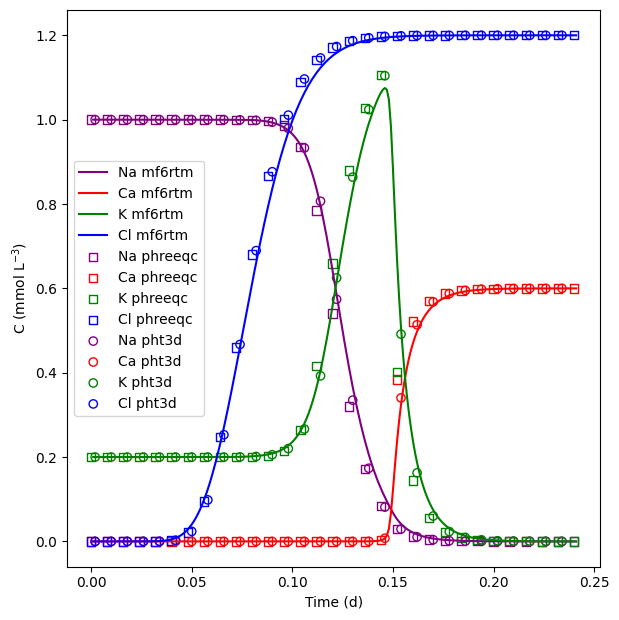

In [13]:
pncol=2
variables = list(simapi.iloc[:,1:-1 ].columns) #dissolved only

pnrow = calc_rows_from_ncol(variables, pncol)

mf6df = simapi[simapi['cell'] == simapi['cell'].max()].copy()
pht3df = simdf[simdf['cell'] == simdf['cell'].max()].copy()
phreeqdf = phreeqcout[phreeqcout['cell'] == phreeqcout['cell'].max()].copy()

colors = ['purple', 'r', 'g', 'b']

fig, axs = plt.subplots(1,1, figsize = (6.3, 6.3))
ax = axs
[ax.plot(mf6df.index, mf6df.loc[:, var]*1000, label = f"{var} mf6rtm", c = colors[variables.index(var)]) for var in variables];
[ax.scatter(phreeqdf.time_d[::4], phreeqdf.loc[:, var][::4]*1000, label = f"{var} phreeqc",  marker = 's',facecolor = 'None', edgecolors = colors[variables.index(var)]) for var in variables];
[ax.scatter(pht3df.index[::4], pht3df.loc[:, var][::4]*1000, label = f"{var} pht3d",  facecolor = 'None', edgecolors = colors[variables.index(var)]) for var in variables];

ax.set_ylabel('C (mmol L$^{-3}$)')
ax.set_xlabel('Time (d)')
ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(f'{prefix}.png'), dpi = 300)

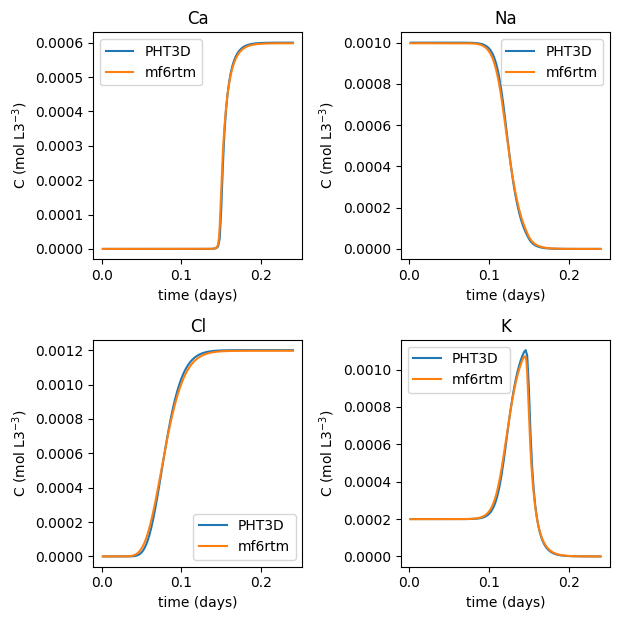

In [14]:
#get common keys from ucndic and ucndic_mf6
common_keys = set(ucndic.keys()).intersection(ucndic_mf6.keys())
common_keys

pncol=2
variables = common_keys

pnrow = calc_rows_from_ncol(variables, pncol)



fig, axs = plt.subplots(pnrow,pncol, figsize = (6.3, 6.3))
for var, ax in zip(common_keys, axs.flatten()):
    ax.plot([x for x in timespht3d], ucndic[var][:,0,0,-1], label = f'PHT3D')
    ax.plot([x for x in times[:]], ucndic_mf6[var][:,0,0,-1]/1000, label = f'mf6rtm')

    #get min and max of y axis
    xmin, xmax = ax.get_ylim()
    # ax.set_ylim(xmin*.8, xmax*1.2)

    ax.set_xlabel('time (days)')
    if var not in ['pH', 'pe']:
        ax.set_ylabel('C (mol L3$^{-3}$)')
    ax.set_title(f'{var}')
    ax.ticklabel_format(useOffset=False)
    ax.legend()
fig.tight_layout()